In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from configs.configs import configs as cfg
import os
import copy

In [2]:
SHEETS = cfg['sheets_names']
DATA_PATH_INIT = cfg['clean_data_path_init']
trans_df = pd.read_csv(os.path.join(DATA_PATH_INIT, 'transactions.csv'))

In [3]:
trans_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [299]:
list(trans_df.columns)

['transaction_id',
 'product_id',
 'customer_id',
 'transaction_date',
 'online_order',
 'order_status',
 'brand',
 'product_line',
 'product_class',
 'product_size',
 'list_price',
 'standard_cost',
 'product_first_sold_date']

In [5]:
trans_df.transaction_date.value_counts()

2017-02-14    82
2017-08-18    82
2017-10-15    76
2017-01-31    73
2017-12-19    71
              ..
2017-01-12    38
2017-12-07    37
2017-03-29    36
2017-09-25    35
2017-10-19    32
Name: transaction_date, Length: 364, dtype: int64

In [6]:
# get only year-month-day data from trans df
trans_df['transaction_date'] = pd.to_datetime(trans_df['transaction_date'], infer_datetime_format=True, errors='coerce')
display(trans_df['transaction_date'].value_counts()[:5])


2017-02-14    82
2017-08-18    82
2017-10-15    76
2017-01-31    73
2017-12-19    71
Name: transaction_date, dtype: int64

In [7]:
trans_df['product_first_sold_date'] = pd.to_datetime(trans_df['product_first_sold_date'], infer_datetime_format=True, errors='coerce', unit='s')
trans_df['product_first_sold_date'][:3]

0   1970-01-01 11:27:25
1   1970-01-01 11:35:01
2   1970-01-01 10:06:01
Name: product_first_sold_date, dtype: datetime64[ns]

### i think it could be diffreant calender but i can't figure it out

In [283]:
pd.Timestamp(41701.0, freq='D', unit='s', tz='Australia/Sydney')

C:\Users\oeb\AppData\Local\Temp/ipykernel_24836/2531839966.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  pd.Timestamp(41701.0, freq='D', unit='s', tz='Australia/Sydney')


Timestamp('1970-01-01 21:35:01+1000', tz='Australia/Sydney', freq='D')

In [ ]:
ts = pd.Timestamp('2017-01-02 04:00:00')
ts
ts.to_julian_date()

2457755.6666666665

> product_first_sold_date is missed up so we have no chioce than take the time excluding the date

In [8]:
trans_df['product_first_sold_date'] = trans_df['product_first_sold_date'].dt.time
trans_df['product_first_sold_date'][:3]

0    11:27:25
1    11:35:01
2    10:06:01
Name: product_first_sold_date, dtype: object

In [63]:
trans_df['product_first_sold_date'].apply(lambda x: x.hour).value_counts()

10.0    7341
11.0    7123
9.0     5339
Name: product_first_sold_date, dtype: int64

In [9]:
def fn(df):
    for col in df.columns:
        yield df[col].value_counts()

values = [i for i in fn(trans_df)]

In [10]:
values[7]

Standard    14176
Road         3970
Touring      1234
Mountain      423
Name: product_line, dtype: int64

In [11]:
trans_df.describe()

,transaction_id,product_id,customer_id,online_order,list_price,standard_cost
count,20000.000000,20000.00000,20000.000000,19640.000000,20000.000000,19803.000000
mean,10000.500000,45.36465,1738.246050,0.500458,1107.829449,556.046951
std,5773.647028,30.75359,1011.951046,0.500013,582.825242,405.955660
min,1.000000,0.00000,1.000000,0.000000,12.010000,7.210000
25%,5000.750000,18.00000,857.750000,0.000000,575.270000,215.140000
50%,10000.500000,44.00000,1736.000000,1.000000,1163.890000,507.580000
75%,15000.250000,72.00000,2613.000000,1.000000,1635.300000,795.100000
max,20000.000000,100.00000,5034.000000,1.000000,2091.470000,1759.850000


> missing values in cols : {online_order, standard_cost, product_first_sold_date}

In [12]:
[trans_df[col].isnull().sum() for col in trans_df.columns]

[0, 0, 0, 0, 360, 0, 197, 197, 197, 197, 0, 197, 197]

In [13]:
trans_dropped_nulls_df = trans_df[ ~ (trans_df['online_order'].isna() | trans_df['brand'].isnull() | trans_df['product_line'].isnull())]
len(trans_dropped_nulls_df)

19445

In [14]:
missing_brand_produt_df = trans_df[ trans_df['brand'].isnull() & trans_df['product_line'].isnull()]
missing_brand_produt_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
136,137,0,431,2017-09-23,0.0,Approved,NaN,NaN,NaN,NaN,1942.61,NaN,NaT
159,160,0,3300,2017-08-27,0.0,Approved,NaN,NaN,NaN,NaN,1656.86,NaN,NaT
366,367,0,1614,2017-03-10,0.0,Approved,NaN,NaN,NaN,NaN,850.89,NaN,NaT
406,407,0,2559,2017-06-14,1.0,Approved,NaN,NaN,NaN,NaN,710.59,NaN,NaT
676,677,0,2609,2017-07-02,0.0,Approved,NaN,NaN,NaN,NaN,1972.01,NaN,NaT


In [15]:
values_brand = [i for i in fn(missing_brand_produt_df)]

In [16]:
values_brand[1]

0    197
Name: product_id, dtype: int64

> definatly not a random missing values its all related to product **Zero**

**could be a sale**

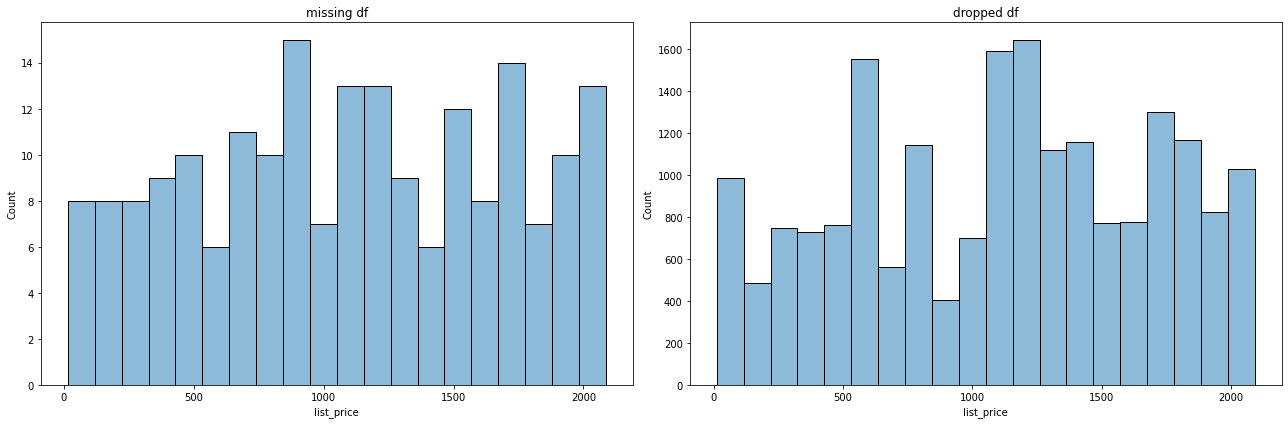

In [17]:
fig, axes = plt.subplots(1,2,figsize=(18,6))
fig.set_tight_layout(True)
sns.histplot(missing_brand_produt_df.list_price, bins=20, alpha=0.5, ax=axes[0]);
sns.histplot(trans_dropped_nulls_df.list_price, bins=20, alpha=0.5, ax=axes[1]);
axes[0].set_title('missing df')
axes[1].set_title('dropped df');

In [18]:
print(missing_brand_produt_df.list_price.mean(), trans_dropped_nulls_df.list_price.mean())
print(missing_brand_produt_df.list_price.std(), trans_dropped_nulls_df.list_price.std())

1090.899695431472 1107.3371931087684
589.5579636386084 582.6623996133477


In [19]:
ratio = missing_brand_produt_df.list_price.mean()/ trans_dropped_nulls_df.list_price.mean()
1 / (ratio) - ratio

0.029912002486310985

> no the prices were stable

*see if it is a seasonality problem or happend as server error*

In [20]:
len(values_brand[3]), len(values[3])

(154, 364)

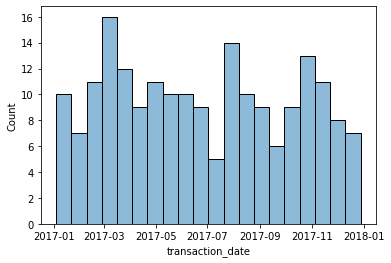

In [21]:
sns.histplot(missing_brand_produt_df.transaction_date, bins=20, alpha=0.5);

> no major difference so NO

### see if it's a brand related

Solex             273
OHM Cycles        240
Norco Bicycles    238
Trek Bicycles     212
Giant Bicycles    101
WeareA2B           93
Name: brand, dtype: int64

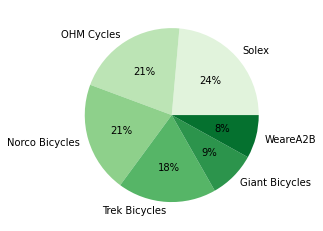

Series([], Name: brand, dtype: int64)

In [22]:
def pie_chart(data):
    labels = list(data.keys())
    #define Seaborn color palette to use
    colors = sns.color_palette('Greens')[:len(data)]

    #create pie chart
    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()

display(trans_dropped_nulls_df[trans_dropped_nulls_df.product_id == 0].brand.value_counts())
pie_chart(trans_dropped_nulls_df[trans_dropped_nulls_df.product_id == 0].brand.value_counts())
missing_brand_produt_df.brand.value_counts()

**IN.6 Solex, OHM Cycles, Norco Bicycles, Trek Bicycles are the highest saled**

> no brands included in the missing data so No

In [23]:
df =  copy.deepcopy(trans_dropped_nulls_df)

In [24]:
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
cols = ['transaction_date','order_status', 'brand', 'product_line','product_class','product_size','product_first_sold_date']
for column in cols:
    df[column] = labelencoder.fit_transform(df[column]) 

In [25]:
corrs = df[['product_id','transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date']].corr()

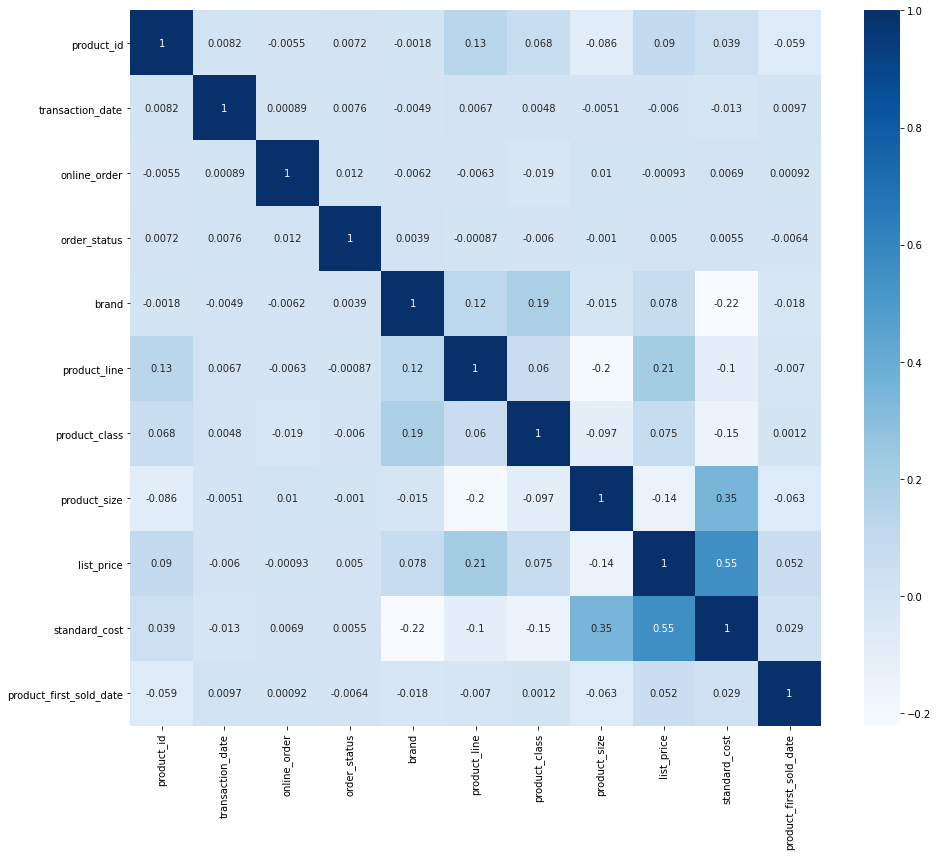

In [26]:
plt.figure(figsize=(14,12))
sns.heatmap(corrs,cmap="Blues", annot=True)
plt.tight_layout()
plt.yticks(rotation=0);

In [27]:
# all related to product_id of 0 only
data = df[df['product_id'] == 0]
corrs = data[['transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date']].corr()

In [28]:
df[df['product_id'] == 0].brand.value_counts()

3    273
2    240
1    238
4    212
0    101
5     93
Name: brand, dtype: int64

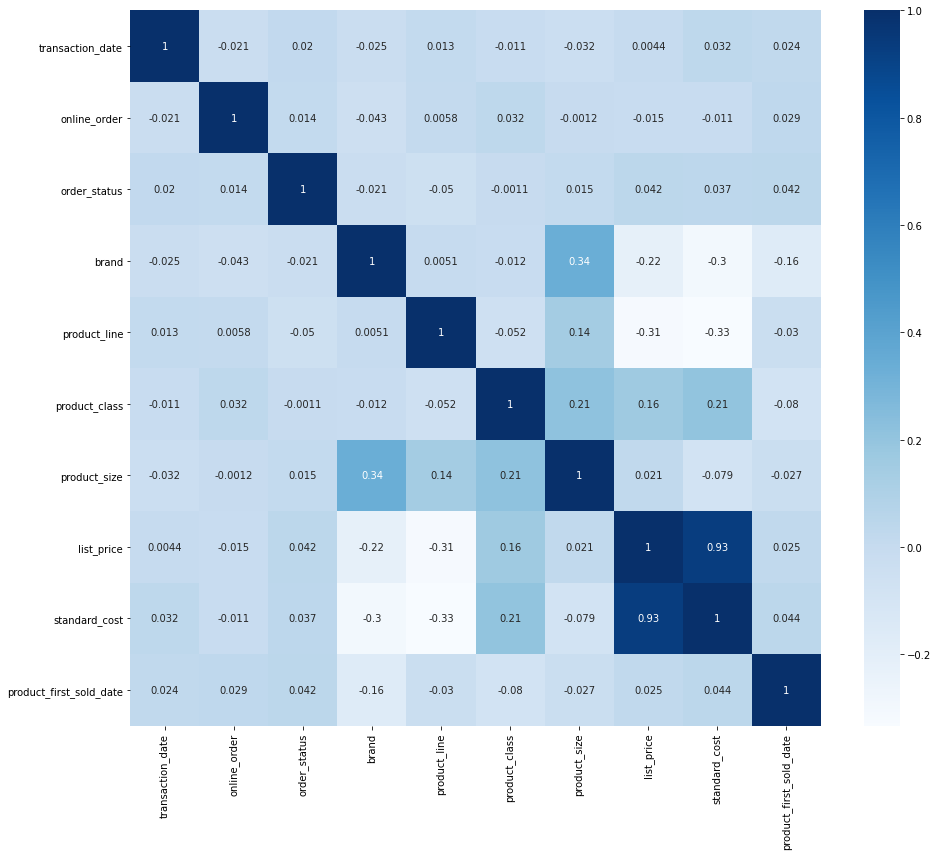

In [29]:
plt.figure(figsize=(14,12))
sns.heatmap(corrs,cmap="Blues", annot=True)
plt.tight_layout()
plt.yticks(rotation=0);

> so we could have recoverd ['product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost'] columns

       if we had ['brands'] in the missing data

>- so unfortunately we we'll drop the data

- highest saled for each month and fill its values


#### probabilities fills

taking a naive bayes approach assuming feature is independent from the other

In [30]:
# trnsform transaction_date to date time
data.transaction_date = pd.to_datetime(data.transaction_date, infer_datetime_format=True, errors='coerce')
data.product_first_sold_date = pd.to_datetime(data.product_first_sold_date, infer_datetime_format=True, errors='coerce')
# data.transaction_date.dt.month.value_counts()

c:\Users\oeb\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [31]:
data = trans_dropped_nulls_df[trans_dropped_nulls_df.product_id == 0]
data.transaction_date = pd.to_datetime(data.transaction_date, infer_datetime_format=True, errors='coerce')
data.product_first_sold_date = pd.to_datetime(data.product_first_sold_date, infer_datetime_format=True, errors='coerce')

# recall from IN.6
# Giant Bicycles , WeareA2B aren't important
data = data[data['brand'] != "WeareA2B"]
data = data[data['brand'] != "Giant Bicycles"]

# group by month
data.transaction_date = data.transaction_date.dt.month

data.groupby(['transaction_date'])['brand'].value_counts()[:3]

c:\Users\oeb\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


transaction_date  brand         
1                 Solex             21
                  Norco Bicycles    20
                  OHM Cycles        19
Name: brand, dtype: int64

In [32]:
data.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

In [33]:
data['product_size'].unique()

array(['medium', 'large'], dtype=object)

In [34]:
data = data.groupby(['transaction_date'])

In [35]:
# 
product_line = data['product_line'].value_counts().unstack()
display(product_line[:3])
# prob for each month
total = product_line.sum(axis=1)
p_standard = product_line['Standard'] / total
p_road = product_line['Road'] / total

product_line,Road,Standard
transaction_date,,
1,21,52
2,18,57
3,23,58


In [36]:
# BRANDS
brands = data['brand'].value_counts().unstack()
display(brands[:3])
# prob for each month
total = brands.sum(axis=1)
p_norco = brands['Norco Bicycles'] / total
p_solex = brands['Solex'] / total
p_ohm = brands['OHM Cycles'] / total
p_trek = brands['Trek Bicycles'] / total

brand,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles
transaction_date,,,,
1,20,19,21,13
2,15,20,22,18
3,16,18,27,20


In [37]:
# classes
classes = data['product_class'].value_counts().unstack()
display(classes[:3])
# prob for each month
total = classes.sum(axis=1)
p_medium = classes['medium'] / total
p_low = classes['low'] / total
p_high = classes['high'] / total

product_class,high,low,medium
transaction_date,,,
1,10,3,60
2,17,9,49
3,15,6,60


In [38]:
# sizes
sizes = data['product_size'].value_counts().unstack()
display(sizes[:3])
# prob for each month
total = sizes.sum(axis=1)
p_medium = sizes['medium'] / total
p_large = sizes['large'] / total

product_size,large,medium
transaction_date,,
1,5,68
2,4,71
3,6,75


In [39]:
data['list_price'].unique()[1]

array([290.62,  71.49, 183.86, 235.63,  71.16, 360.4 , 416.98, 544.05,
        12.01, 499.53, 100.35, 441.49, 363.01, 227.88, 478.16, 358.39,
       533.51, 742.54, 202.62, 495.72, 543.39])

In [40]:
np.quantile(data['list_price'].value_counts()[1],  q=[0.25, 0.5, 0.75])

array([1., 2., 5.])

In [185]:
# transform groupby object to dataframe
data = trans_dropped_nulls_df[trans_dropped_nulls_df.product_id == 0]
# recall from IN.6
# Giant Bicycles , WeareA2B aren't important
data = data[data['brand'] != "WeareA2B"]
data = data[data['brand'] != "Giant Bicycles"]

# group by month
data.transaction_date = data.transaction_date.dt.month

data.groupby(['transaction_date'])['brand'].value_counts()[:4]
data = data.groupby(['transaction_date']).size().reset_index(name = 'count')
['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date']
# # data = data.reset_index()
# data.columns
# # data = data.groupby(['transaction_date'])

data.head()

,transaction_date,count
0,1,73
1,2,75
2,3,81
3,4,77
4,5,84


In [42]:
data

,transaction_date,count
0,1,73
1,2,75
2,3,81
3,4,77
4,5,84
5,6,79
6,7,88
7,8,76
8,9,86
9,10,88


In [182]:
trans_dropped_nulls_df[trans_dropped_nulls_df.product_id == 0]

34        8
39       11
54        9
60        2
63        7
         ..
19921     1
19941     7
19967     4
19987     4
19988     4
Name: transaction_date, Length: 1157, dtype: int64

In [187]:
# Prices
data = trans_dropped_nulls_df[trans_dropped_nulls_df.product_id == 0]
data.transaction_date = data.transaction_date.dt.month

data = data[data['brand'] != "WeareA2B"]
data = data[data['brand'] != "Giant Bicycles"]

prices_df = data.groupby(['transaction_date','brand'])[['list_price','standard_cost']].agg(['median'])
cols = ['list_price','standard_cost']
list_price = []
standard_cost = []

for i in range(1,13):
    list_price.append(prices_df['list_price']['median'][i])
    standard_cost.append(prices_df['standard_cost']['median'][i])

    # prices_cats = np.quantile(data['list_price'].unique()[i],  q=[0.25, 0.5, 0.75])
    # print(prices_cats)
    # data['list_price'][data['list_price'] <= prices_cats[0]] = 1
    # data['list_price'][(data['list_price'] > prices_cats[0]) & (data['list_price'] <= prices_cats[1])] = 2
    # data['list_price'][(data['list_price'] > prices_cats[1]) & (data['list_price'] <= prices_cats[2])] = 3

brands_dict = {'Norco Bicycles':0, 'OHM Cycles':1, 'Solex':2, 'Trek Bicycles':3}

# import enum
# class Brands(enum.Enum):
#     Norco = 0
#     OHM = 1
#     Solex = 2
#     Trek = 3

c:\Users\oeb\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [188]:
prices_df.head()

list_price standard_cost
                                    median        median
transaction_date brand                                  
1                Norco Bicycles     360.40        270.30
                 OHM Cycles         235.63        125.07
                 Solex              100.35         75.26
                 Trek Bicycles      358.39        215.14
2                Norco Bicycles     363.01        290.41

In [193]:
prices_df['standard_cost']['median'][1]['Solex']

75.26

In [190]:
prices_df['standard_cost']['median'].index

MultiIndex([( 1, 'Norco Bicycles'),
            ( 1,     'OHM Cycles'),
            ( 1,          'Solex'),
            ( 1,  'Trek Bicycles'),
            ( 2, 'Norco Bicycles'),
            ( 2,     'OHM Cycles'),
            ( 2,          'Solex'),
            ( 2,  'Trek Bicycles'),
            ( 3, 'Norco Bicycles'),
            ( 3,     'OHM Cycles'),
            ( 3,          'Solex'),
            ( 3,  'Trek Bicycles'),
            ( 4, 'Norco Bicycles'),
            ( 4,     'OHM Cycles'),
            ( 4,          'Solex'),
            ( 4,  'Trek Bicycles'),
            ( 5, 'Norco Bicycles'),
            ( 5,     'OHM Cycles'),
            ( 5,          'Solex'),
            ( 5,  'Trek Bicycles'),
            ( 6, 'Norco Bicycles'),
            ( 6,     'OHM Cycles'),
            ( 6,          'Solex'),
            ( 6,  'Trek Bicycles'),
            ( 7, 'Norco Bicycles'),
            ( 7,     'OHM Cycles'),
            ( 7,          'Solex'),
            ( 7,  'Trek Bicy

In [173]:
standard_cost

[215.14,
 270.3,
 337.3050122,
 84.99,
 66.14,
 298.72,
 215.14,
 407.54,
 56.93,
 53.62,
 131.92,
 7.21]

In [56]:
# product_first_sold_date
# we'll impute by hour
# applay function to each row
data['product_first_sold_date'] = data['product_first_sold_date'].apply(lambda x: x.hour)

c:\Users\oeb\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [62]:
data['product_first_sold_date'].value_counts()

10    487
11    408
9     262
Name: product_first_sold_date, dtype: int64

In [66]:
data.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
34,35,0,2171,2017-08-20,0.0,Approved,Norco Bicycles,Road,medium,medium,544.05,376.84,10
39,40,0,2448,2017-11-28,1.0,Approved,Norco Bicycles,Road,medium,medium,544.05,376.84,10
54,55,0,3140,2017-09-18,0.0,Approved,Norco Bicycles,Standard,low,medium,363.01,290.41,10
60,61,0,1839,2017-02-24,0.0,Approved,OHM Cycles,Road,high,large,12.01,7.21,9
63,64,0,2000,2017-07-08,0.0,Approved,Trek Bicycles,Standard,medium,medium,499.53,388.72,10


In [65]:
# product_first_sold_date
# we'll impute by hour
# data['product_first_sold_date'] = pd.to_datetime(data['product_first_sold_date'], infer_datetime_format=True, errors='coerce', unit='s')
# data['product_first_sold_date'] = data['product_first_sold_date'].hour
# data['product_first_sold_date'].value_counts()
# data['product_first_sold_date']


In [71]:
data['product_first_sold_date'].value_counts().values, data['product_first_sold_date'].value_counts().index

(array([487, 408, 262], dtype=int64), Int64Index([10, 11, 9], dtype='int64'))

In [90]:
sold_dates = pd.DataFrame(data['product_first_sold_date'].value_counts().values, data['product_first_sold_date'].value_counts().index, columns=['count'])
# rename index
sold_dates = sold_dates.reset_index()
sold_dates = sold_dates.rename(columns={'index':'hour'})
# sold_dates.index.name = 'hour'
sold_dates


,hour,count
0,10,487
1,11,408
2,9,262


In [98]:
sold_dates['count'].sum()

1157

In [101]:
# assume date is independent of other features

sold_dates = pd.DataFrame(data['product_first_sold_date'].value_counts().values, data['product_first_sold_date'].value_counts().index, columns=['count'])
# rename index
sold_dates = sold_dates.reset_index()
sold_dates = sold_dates.rename(columns={'index':'hour'})
display(sold_dates[:3])
# prob for each month
total = sold_dates['count'].sum()
p_ten = sold_dates['count'][0] / total
p_eleven = sold_dates['count'][1] / total
p_nine = sold_dates['count'][2] / total


,hour,count
0,10,487
1,11,408
2,9,262


In [102]:
p_ten, p_eleven, p_nine

(0.4209161624891962, 0.3526361279170268, 0.226447709593777)

## Random semi naive bayes algorithm

we have two approaches 
- impute by naive bayes algorithm
    
        but this will always choose the maximum probability value
        which will result in a duplicate value

- impute by random sampling

        would contribute in less duplicates


> so we'll take the second approach

#### steps

1. random weighted sample brands depending on the transaction month

2. choose 'standard_cost' based on transaction month and imputed brand

3. random weighted sample [product_line, 'product_class', 'product_size', 'product_first_sold_date']


In [106]:
brands_dict

{'Norco Bicycles': 0, 'OHM Cycles': 1, 'Solex': 2, 'Trek Bicycles': 3}

In [ ]:
# # weighted choice
# def weighted_choice(weights):
#     totals = []
#     running_total = 0

#     for w in weights:
#         running_total += w
#         totals.append(running_total)

#     rnd = random.random() * running_total
#     for i, total in enumerate(totals):
#         if rnd < total:
#             return i

In [168]:
weights = pd.concat([p_norco, p_ohm, p_solex, p_trek], axis=1)
brands_names = np.array(list(brands_dict.keys()))

# ! central theroem of limit the brands will maintain the same distribution
# first random weighted sample of brands

def impute_brand(month: int) -> str:
    return str(np.random.choice(brands_names, 1, p=weights.loc[month-1].values)[0])

# def impute_brand(row):
#     # get probabilities for each brand
#     p_norco = brands['Norco Bicycles'] / total
#     p_ohm = brands['OHM Cycles'] / total
#     p_solex = brands['Solex'] / total
#     p_trek = brands['Trek Bicycles'] / total
#     # weighted choice
#     return np.random.choice(brands_dict.keys(), p=weights)
impute_brand(10)

'Trek Bicycles'

In [206]:
# create a datetime variable
pd.Timestamp('11:00:00').hour

11

In [297]:
# impute product_first_sold_date
dates_names = ['10:00:00', '11:00:00', '09:00:00']
dates_weights = np.array([p_ten, p_eleven, p_nine])
def impute_product_first_sold_date() -> pd.Timestamp:
    x = np.random.choice(dates_names, 1, p=dates_weights)[0]
    return pd.Timestamp(str(x)).hour

impute_product_first_sold_date()

11

In [197]:
standard_cost[5]['Solex']

84.99

In [108]:
# assume date is independent of other features
# pick a random brand weighted by probability

# product_line
p_standard, p_road

# product_class
p_medium, p_low, p_high

# product_size
p_medium, p_large

# list_price, standard_cost
standard_cost

# ! CONSTAT
# product_first_sold_date
p_ten, p_eleven, p_nine

(0.4209161624891962, 0.3526361279170268, 0.226447709593777)

In [202]:
p_standard

transaction_date
1     0.712329
2     0.760000
3     0.716049
4     0.610390
5     0.690476
6     0.632911
7     0.568182
8     0.671053
9     0.709302
10    0.670455
11    0.675000
12    0.763158
dtype: float64

In [133]:
z = np.poly1d(np.polyfit(np.array(list_price), np.array(standard_cost), 2))

round(z(800),3)

In [ ]:
# curve fitting to price_list and standard_cost
# price_list = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
# standard_cost = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
# plt.plot(price_list, standard_cost)
# plt.show()

In [111]:
len(list_price), p_medium, p_standard, p_norco

12

In [136]:
p_norco

transaction_date
1     0.273973
2     0.200000
3     0.197531
4     0.298701
5     0.273810
6     0.227848
7     0.215909
8     0.263158
9     0.197674
10    0.215909
11    0.300000
12    0.315789
dtype: float64

In [ ]:
trans_df.drop( )

## first Online order

In [97]:
print(trans_df['online_order'].isna().sum())
missing_online_orders_df = trans_df[trans_df['online_order'].isna()]
missing_online_orders_df.head()

360


,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
97,98,49,333,2017-06-23,NaN,Approved,Trek Bicycles,Road,medium,medium,533.51,400.13,37823.0
166,167,90,3177,2017-04-26,NaN,Approved,Norco Bicycles,Standard,low,medium,363.01,290.41,38482.0
169,170,6,404,2017-10-16,NaN,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,37838.0
250,251,63,1967,2017-04-11,NaN,Approved,Solex,Standard,medium,medium,1483.20,99.59,42145.0
300,301,78,2530,2017-03-24,NaN,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,35455.0


> 360 rows is not a big deal but for such a feature (online_order) it not worth to drop 360 rows just for it 

**so we'll keep digging for possible fillings**

In [95]:
values[7], values[6]

(Standard    14176
 Road         3970
 Touring      1234
 Mountain      423
 Name: product_line, dtype: int64,
 Solex             4253
 Giant Bicycles    3312
 WeareA2B          3295
 OHM Cycles        3043
 Trek Bicycles     2990
 Norco Bicycles    2910
 Name: brand, dtype: int64)

In [100]:
missing_online_orders_df.product_line.value_counts()

Standard    256
Road         76
Touring      21
Mountain      5
Name: product_line, dtype: int64

In [99]:
values[5]

Approved     19821
Cancelled      179
Name: order_status, dtype: int64

In [101]:
missing_online_orders_df.order_status.value_counts()

Approved     354
Cancelled      6
Name: order_status, dtype: int64

In [ ]:

def dates(df, col):

In [15]:
trans_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [14]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

In [27]:
trans_df.transaction_date.describe()

C:\Users\oeb\AppData\Local\Temp/ipykernel_4184/3318618553.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  trans_df.transaction_date.describe()


count                   20000
unique                    364
top       2017-02-14 00:00:00
freq                       82
first     2017-01-01 00:00:00
last      2017-12-30 00:00:00
Name: transaction_date, dtype: object

In [25]:
trans_df.transaction_date[32]

Timestamp('2017-03-20 00:00:00')